## 09/16 과제 1
---
- VGG16 모델 활용 이미지 식별 모델
- CiFar10 데이터 사용

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
from PIL import Image  as pilimg
import os
(train_x, train_y), (test_x, test_y) = load_data()
train_x = train_x/255.0
test_x = test_x/255.0
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [2]:
# 사전 학습 모델 불러오기
input_tensor = Input(shape = (32, 32, 3))
model = VGG16(weights = 'imagenet', include_top = False, input_tensor = input_tensor)

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [4]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

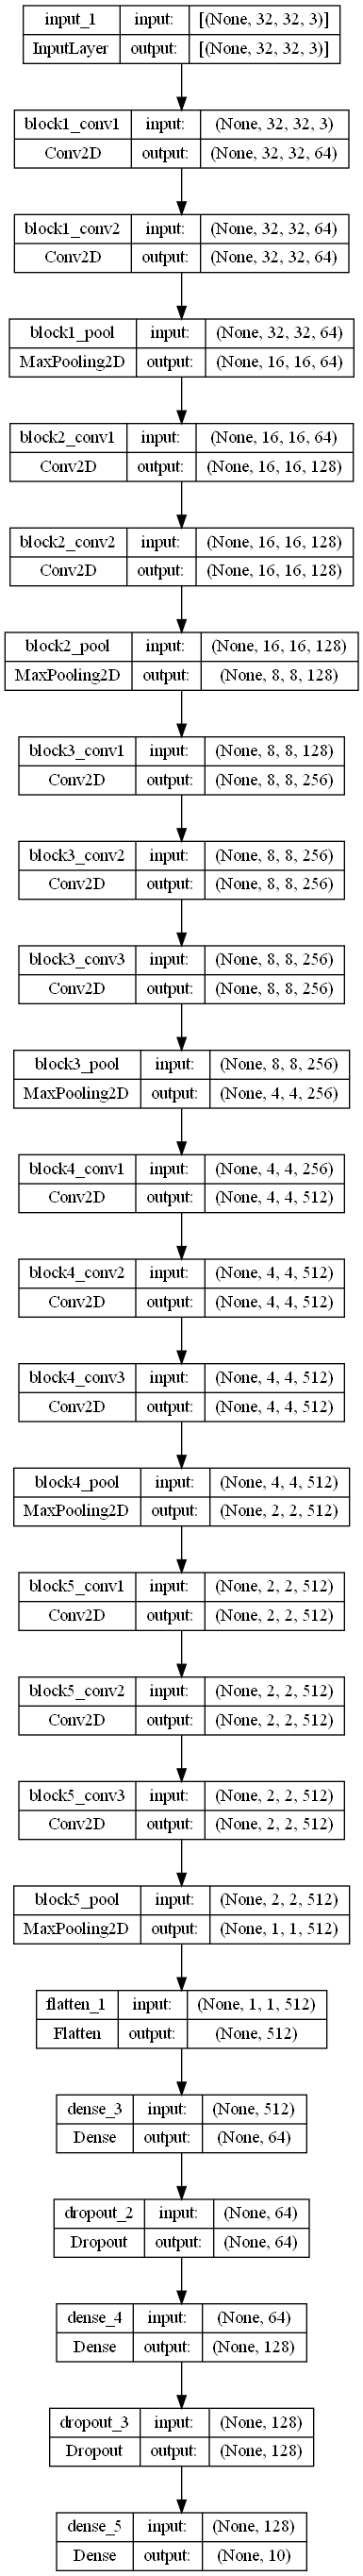

In [7]:
x = layer_dict['block5_pool'].output
# x = Conv2D(
#     filters = 10, 
#     kernel_size=3, 
#     activation='relu',
#     padding='same'
# )(x)
# x = MaxPool2D()(x)
# x = Conv2D(
#     filters = 15, 
#     kernel_size=3, 
#     activation='relu',
#     padding='same'
# )(x)
# x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(10, activation='softmax')(x)
new_model = Model(inputs = model.input, outputs =x)

for layer in new_model.layers[:19] :
    layer.trainable = False
    
new_model.summary()

new_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
plot_model(new_model,show_shapes=True)

In [ ]:
model_path = './cifar_best_model.h5'

es_cb =  EarlyStopping(monitor= 'val_loss', patience=5)
mc_cb = ModelCheckpoint(monitor= 'val_loss', filepath = model_path)

result = new_model.fit(
    train_x, train_y, 
    validation_split=0.2,
    batch_size = 400,
    epochs = 500,
    callbacks= [es_cb, mc_cb]
)

Epoch 1/500
 55/100 [===============>..............] - ETA: 13:34 - loss: 2.0563 - accuracy: 0.2520

In [ ]:

plt.style.use('ggplot')
for k in result.history.keys():
    plt.plot(result.epoch, result.history[k], label = k)
    
plt.legend()
plt.show()

In [ ]:
new_model = load_model(model_path)

In [ ]:
plt.matshow(test_x[0], cmap = 'gray_r')
pred = new_model.predict(test_x[[0]])
print(test_y[0])
print(np.round(pred,2))

In [ ]:
img_list = os.listdir('./test_img/')
for i in range(len(img_list)):
    image = pilimg.open('./test_img/'+img_list[i])
    
    pix = np.array(image)
    pred = new_model.predict(pix.reshape(-1, 32,32,3))
    print(np.round(pred,2))
    plt.imshow(pix)
    plt.show()